In [1]:
import numpy as np
from sklearn import datasets
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from matplotlib import colors
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from math import pi
#try DBScan
from sklearn.cluster import DBSCAN
from sklearn.pipeline import Pipeline
# %pip install opentsne
# from openTSNE import TSNEEmbedding
# from openTSNE.affinity import PerplexityBasedNN
# from openTSNE import initialization
# from openTSNE.callbacks import ErrorLogger

from cuml import TSNE as cumlTSNE
from cuml import PCA as cumlPCA
import cudf
from sys import exit

from mnist import MNIST

# the path should point to the FIt-SNE directory
import sys; sys.path.append('FIt-SNE/')
from fast_tsne import fast_tsne

from sklearn.model_selection import KFold
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score
from sys import exit
from itertools import permutations

In [2]:
#
#Perform tSNE and get the embedded data
#
def get_clusters( dataset, eps_multiplier=1, late_exag=False ):
    #
    #scale the data
#     scaler = StandardScaler()
#     dataset = scaler.fit_transform(dataset)
    
    #fast tsne
    # Do PCA and keep 50 dimensions
    X = np.array(dataset) - np.array(dataset).mean(axis=0)
    U, s, V = np.linalg.svd(dataset, full_matrices=False)
    X50 = np.dot(U, np.diag(s))[:,:50]
    if late_exag:
        X_embed = fast_tsne(X50, late_exag_coeff=4)
    else:
        X_embed = fast_tsne(X50)

    #
    #get pairwise distances of embedding, set zeros to inf for min function to follow
    pair_dist = pairwise_distances(X_embed)

    #
    #create the clusters
    clusters = []

    #
    #set epsilon
    d = np.mean(pair_dist) * eps_multiplier

    #
    #DBSCAN
    dbscan = DBSCAN(eps=d, min_samples=1)#int(dataset.shape[0]*0.015))
    clustering = dbscan.fit( X_embed )
    for i in range(np.min(clustering.labels_),np.max(clustering.labels_)+1):
        clusters.append( np.argwhere( clustering.labels_ == i ).flatten().tolist() )
    
    del dbscan
    del clustering

    clusters.sort(key=len)
    return X_embed, clusters[::-1]

In [3]:
#
#Perfrom random forest classification and show the error
#
def get_explanatory_importances(dataset,clusters,feature_names):
    #
    #infer labels from clusters
    labels = np.zeros(dataset.shape[0])
    for idx, cluster in enumerate( clusters ):
        labels[cluster] = idx

    #
    #scale the data
    #Fit RF and get predictions
    rf = Pipeline([('scaler',StandardScaler()),('rf',RandomForestClassifier())])
    rf.fit( dataset, labels )
    predictions = rf.predict( dataset )

    #
    #Show the important features

    return sorted(zip(rf['rf'].feature_importances_,feature_names))[::-1], predictions, rf

In [4]:
#
#technique using Cross validation for selecting the optimal epsilon
#
def get_epsilon( this_dataset, lower_limit=1 ):
    folds = KFold(n_splits=5, shuffle=False, random_state=None)

    eps_list = []
    f1_list = []
    
    for eps_multiplier in np.linspace(0.001,0.5,10):
        f1_scores = []
        accs = []
        precisions = []
        recall = []

        X_embedded, clusters = get_clusters( this_dataset, eps_multiplier )
        
        if len(clusters) <= lower_limit:
            continue
            
        sorted_list, predictions, rf = get_explanatory_importances(this_dataset, clusters, feature_names)
        
        

        for train_index, test_index in folds.split(this_dataset):
            train_data, test_data = np.array(this_dataset)[train_index], np.array(this_dataset)[test_index]
            X_embedded1, clusters1 = get_clusters( train_data, eps_multiplier )
            
            sorted_list1, predictions1, rf1 = get_explanatory_importances(train_data, clusters1, feature_names)

            best_perm = []

            for c1 in clusters1:
                best_sum = 0
                best_cluster = None
                for idx, c in enumerate(clusters):
                    this_sum = len(list(set(c) & set(train_index[c1])))
                    if this_sum > best_sum and idx not in best_perm:
                        best_sum = this_sum
                        best_cluster = idx
                best_perm.append(best_cluster)
#             print(best_perm)

            rf1_predictions = rf1.predict(test_data)
            rf_predictions = rf.predict(test_data)

            rf_predictions = list(map(lambda x: best_perm.index(x) if x in best_perm else 0, rf_predictions))


            f1_scores.append( f1_score(rf_predictions, rf1_predictions, average='weighted' ) )
            accs.append( accuracy_score(rf_predictions, rf1_predictions, normalize=True ) )
            precisions.append( precision_score(rf_predictions, rf1_predictions, average='weighted' ) )
            recall.append( recall_score(rf_predictions, rf1_predictions, average='weighted' ) )
        print(eps_multiplier, np.mean(accs), np.mean(precisions), np.mean(recall), np.mean(f1_scores))
        
        eps_list.append( eps_multiplier )
        f1_list.append( np.mean( f1_scores ) )
        
    return np.mean( np.array(eps_list)[np.where(f1_list == np.max(f1_list))] )


In [5]:
#
#MNIST
#
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784')
X = mnist.data
y = mnist.target.astype('int')
print(X)
dataset = np.array(X)#np.random.choice(len(train_images), 30000)]
feature_names = range(dataset.shape[1])

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [6]:
folds = KFold(n_splits=5, shuffle=False, random_state=None)

f1_scores = []
accs = []
precisions = []
recall = []
eps_params_used = []

import tracemalloc

tracemalloc.start()

for train_index, test_index in folds.split(dataset):
    train_data, test_data = np.array(dataset)[train_index], np.array(dataset)[test_index]
    
    eps_multiplier = 0.0055 #get_epsilon(train_data, 5)
    print('eps %s' % eps_multiplier)
    eps_params_used.append( eps_multiplier )
    
    X_embedded, clusters = get_clusters( dataset, eps_multiplier, late_exag=True )
    sorted_list, predictions, rf = get_explanatory_importances(dataset, clusters, feature_names)
    
    ##
    snapshot = tracemalloc.take_snapshot()
    top_stats = snapshot.statistics('lineno')

    print("[ Top 20 ]")
    for stat in top_stats[:20]:
        print(stat)
    ##

    X_embedded1, clusters1 = get_clusters( train_data, eps_multiplier, late_exag=True )
    sorted_list1, predictions1, rf1 = get_explanatory_importances(train_data, clusters1, feature_names)

    best_perm = []

    for c1 in clusters1:
        best_sum = 0
        best_cluster = None
        for idx, c in enumerate(clusters):
            this_sum = len(list(set(c) & set(train_index[c1])))
            if this_sum > best_sum and idx not in best_perm:
                best_sum = this_sum
                best_cluster = idx
        best_perm.append(best_cluster)
#     print(best_perm)

    rf1_predictions = rf1.predict(test_data)
    rf_predictions = rf.predict(test_data)

    rf_predictions = list(map(lambda x: best_perm.index(x) if x in best_perm else 0, rf_predictions))


    f1_scores.append( f1_score(rf_predictions, rf1_predictions, average='weighted' ) )
    accs.append( accuracy_score(rf_predictions, rf1_predictions, normalize=True ) )
    precisions.append( precision_score(rf_predictions, rf1_predictions, average='weighted' ) )
    recall.append( recall_score(rf_predictions, rf1_predictions, average='weighted' ) )
    
    print(eps_multiplier, np.mean(accs), np.mean(precisions), np.mean(recall), np.mean(f1_scores))
    
    del X_embedded, clusters, sorted_list, predictions, rf
    del X_embedded1, clusters1, sorted_list1, predictions1, rf1
    del train_data, test_data

#X_embedded, clusters = get_clusters( dataset, 30, 0.16 ) #MINST
 #Iris

eps 0.0055
[ Top 20 ]
<ipython-input-6-f9a5d83ac42c>:14: size=419 MiB, count=4, average=105 MiB
/home/jefferythewind/anaconda3/envs/rapids3/lib/python3.7/site-packages/sklearn/cluster/_dbscan.py:352: size=2565 KiB, count=74, average=34.7 KiB
<ipython-input-2-aa4f418b0079>:37: size=2454 KiB, count=70952, average=35 B
FIt-SNE/fast_tsne.py:314: size=1094 KiB, count=3, average=365 KiB
/home/jefferythewind/anaconda3/envs/rapids3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:328: size=961 KiB, count=203, average=4848 B
/home/jefferythewind/anaconda3/envs/rapids3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:438: size=547 KiB, count=2, average=273 KiB
/home/jefferythewind/anaconda3/envs/rapids3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:79: size=547 KiB, count=2, average=273 KiB
/home/jefferythewind/anaconda3/envs/rapids3/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:632: size=547 KiB, count=2, average=273 KiB
/home/jefferythewind/anaconda3/

/home/jefferythewind/anaconda3/envs/rapids3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jefferythewind/anaconda3/envs/rapids3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.0055 0.9426428571428571 0.9272184767260424 0.9426428571428571 0.9340154639763557
eps 0.0055
[ Top 20 ]
<ipython-input-6-f9a5d83ac42c>:14: size=419 MiB, count=4, average=105 MiB
/home/jefferythewind/anaconda3/envs/rapids3/lib/python3.7/site-packages/sklearn/cluster/_dbscan.py:352: size=2565 KiB, count=76, average=33.8 KiB
<ipython-input-2-aa4f418b0079>:37: size=2454 KiB, count=70959, average=35 B
FIt-SNE/fast_tsne.py:314: size=1094 KiB, count=3, average=365 KiB
/home/jefferythewind/anaconda3/envs/rapids3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:328: size=965 KiB, count=202, average=4892 B
/home/jefferythewind/anaconda3/envs/rapids3/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:632: size=656 KiB, count=4, average=164 KiB
/home/jefferythewind/anaconda3/envs/rapids3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:438: size=547 KiB, count=2, average=273 KiB
/home/jefferythewind/anaconda3/envs/rapids3/lib/python3.7/site-packages/sklearn/model_selection/_

/home/jefferythewind/anaconda3/envs/rapids3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jefferythewind/anaconda3/envs/rapids3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.0055 0.9118214285714286 0.9081909513550203 0.9118214285714286 0.8996975243129035
eps 0.0055
[ Top 20 ]
<ipython-input-6-f9a5d83ac42c>:14: size=419 MiB, count=4, average=105 MiB
/home/jefferythewind/anaconda3/envs/rapids3/lib/python3.7/site-packages/sklearn/cluster/_dbscan.py:352: size=2565 KiB, count=76, average=33.8 KiB
<ipython-input-2-aa4f418b0079>:37: size=2454 KiB, count=70956, average=35 B
FIt-SNE/fast_tsne.py:314: size=1094 KiB, count=3, average=365 KiB
/home/jefferythewind/anaconda3/envs/rapids3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:328: size=963 KiB, count=202, average=4880 B
/home/jefferythewind/anaconda3/envs/rapids3/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:632: size=656 KiB, count=4, average=164 KiB
/home/jefferythewind/anaconda3/envs/rapids3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:438: size=547 KiB, count=2, average=273 KiB
/home/jefferythewind/anaconda3/envs/rapids3/lib/python3.7/site-packages/sklearn/model_selection/_

/home/jefferythewind/anaconda3/envs/rapids3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jefferythewind/anaconda3/envs/rapids3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.0055 0.9013809523809524 0.9127219210765456 0.9013809523809524 0.8964742514163012
eps 0.0055
[ Top 20 ]
<ipython-input-6-f9a5d83ac42c>:14: size=419 MiB, count=4, average=105 MiB
/home/jefferythewind/anaconda3/envs/rapids3/lib/python3.7/site-packages/sklearn/cluster/_dbscan.py:352: size=2565 KiB, count=76, average=33.8 KiB
<ipython-input-2-aa4f418b0079>:37: size=2454 KiB, count=70959, average=35 B
FIt-SNE/fast_tsne.py:314: size=1094 KiB, count=3, average=365 KiB
/home/jefferythewind/anaconda3/envs/rapids3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:328: size=965 KiB, count=202, average=4892 B
/home/jefferythewind/anaconda3/envs/rapids3/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:632: size=656 KiB, count=4, average=164 KiB
/home/jefferythewind/anaconda3/envs/rapids3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:438: size=547 KiB, count=2, average=273 KiB
/home/jefferythewind/anaconda3/envs/rapids3/lib/python3.7/site-packages/sklearn/model_selection/_

/home/jefferythewind/anaconda3/envs/rapids3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jefferythewind/anaconda3/envs/rapids3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.0055 0.9104285714285715 0.9144307042580466 0.9104285714285715 0.9042530285851228
eps 0.0055
[ Top 20 ]
<ipython-input-6-f9a5d83ac42c>:14: size=419 MiB, count=4, average=105 MiB
/home/jefferythewind/anaconda3/envs/rapids3/lib/python3.7/site-packages/sklearn/cluster/_dbscan.py:352: size=2565 KiB, count=76, average=33.8 KiB
<ipython-input-2-aa4f418b0079>:37: size=2454 KiB, count=70951, average=35 B
FIt-SNE/fast_tsne.py:314: size=1094 KiB, count=3, average=365 KiB
/home/jefferythewind/anaconda3/envs/rapids3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:328: size=959 KiB, count=202, average=4860 B
/home/jefferythewind/anaconda3/envs/rapids3/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:632: size=656 KiB, count=4, average=164 KiB
/home/jefferythewind/anaconda3/envs/rapids3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:438: size=547 KiB, count=2, average=273 KiB
/home/jefferythewind/anaconda3/envs/rapids3/lib/python3.7/site-packages/sklearn/model_selection/_

/home/jefferythewind/anaconda3/envs/rapids3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jefferythewind/anaconda3/envs/rapids3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.0055 0.9176142857142857 0.9177971144745941 0.9176142857142857 0.9109862284470885


   Eps Param Used  Mean Accuracy  Mean Precision  Mean Recall  Mean F1 Score
0          0.0055       0.917614        0.917797     0.917614       0.910986


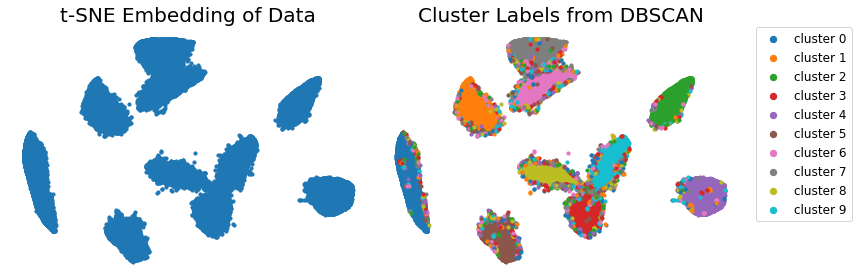

In [8]:
#
#plot embedding only and clusters
#
print(pd.DataFrame({
    'Eps Param Used':[np.mean(eps_params_used)],
    'Mean Accuracy':[np.mean(accs)],
    'Mean Precision':[np.mean(precisions)],
    'Mean Recall':[np.mean(recall)],
    'Mean F1 Score':[np.mean(f1_scores)]
}))
#print(np.mean(eps_params_used), np.mean(accs), np.mean(precisions), np.mean(recall), np.mean(f1_scores))

X_embedded, clusters = get_clusters( dataset, 0.0055, late_exag=True )

dotsize = 10

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
fig.set_figwidth(12)
ax1.scatter(X_embedded[:,0],X_embedded[:,1], alpha=1, s=dotsize)
ax1.set_title('t-SNE Embedding of Data', fontsize=20)

for idx, cluster in enumerate( clusters ):
    if idx < 10:
        ax2.scatter(X_embedded[cluster,0],X_embedded[cluster,1], alpha=1,label="cluster %s" % idx, s=dotsize)
    else:
        ax2.scatter(X_embedded[cluster,0],X_embedded[cluster,1], alpha=1, s=dotsize)

ax2.set_title("Cluster Labels from DBSCAN", fontsize=20)

ax1.axis('off')
ax2.axis('off')

lgnd = ax2.legend(bbox_to_anchor=(1.04,1), borderaxespad=0, prop={"size":12})
for handle in lgnd.legendHandles:
    handle.set_sizes([40.0])

fig.tight_layout()
plt.show()
fig.savefig("Plots1")